# Numerical Scientific Computing Miniproject 1

### Setting up packages and parameters

In [6]:
import numpy as numerinopyndarino
import matplotlib.pyplot as ploterino
import multiprocessing as mp
from numba import jit
import timeit

In [7]:
#Parameters
pim = 500
pre = 500
I = 100
T = 2

### Generate the complex matrix C

In [8]:
C = numerinopyndarino.zeros((pim, pre), dtype=complex) #Generate the C matrix with the given dimesion pim x pre
re = numerinopyndarino.tile(numerinopyndarino.linspace(-2, 1, pim),(pim,1)) #Generate real numbers from -2 to 1, with pim intervals (Stored in a pim x pim matrix)
im = numerinopyndarino.tile(numerinopyndarino.linspace(1.5, -1.5, pre), (pre,1)).T #Generate imaginary numbers from -1.5 to 1.5 with pre intervals (Stored in a pre x pre matrix)
C = re + im*1j

### Naive Implementation

In [9]:

#Naive
def naive(C, I, T):
    M = numerinopyndarino.zeros(C.shape) #Declare our output matrix M

    for row in range(C.shape[0]):  #Loop through each complex number c in our C matrix
        for col in range(C.shape[1]):

            c = C[row, col]
            z = 0 + 0j

            for i in range(I-1): #Calculate I iterations of z with formula: z_(i+1) = z_i ^2 + c
                
                z = (z**2) + c

                if (numerinopyndarino.abs(z) > T): #Calculate l(c) as the index where |z_i| > T
                    lc = i
                    break
                else:
                    lc = I

            M[row, col] = lc/I #Store lc to the output matrix M. We divide by I to map from 0-1.
    return M

M = naive(C, I, T)

### Vectorized implementation

In [10]:
#Vectorized
def vectorized(C, I, T):
    M = numerinopyndarino.zeros(C.shape, dtype=int) #Declare our output matrix M

    Z = numerinopyndarino.zeros(C.shape, dtype=complex) #Declare Z as a matrix, where we calculate z = z²+c for each point in C

    for i in range(I-1):
        Z = Z*Z + C

        M[numerinopyndarino.abs(Z) > T] = i

    M[numerinopyndarino.abs(Z) <= T] = I

    return M

M = vectorized(C, I, T)

/tmp/ipykernel_52709/984938849.py:8: RuntimeWarning: overflow encountered in multiply
  Z = Z*Z + C
/tmp/ipykernel_52709/984938849.py:8: RuntimeWarning: invalid value encountered in multiply
  Z = Z*Z + C
/tmp/ipykernel_52709/984938849.py:10: RuntimeWarning: overflow encountered in absolute
  M[numerinopyndarino.abs(Z) > T] = i


### Numba implementation on naive

In [11]:
#Numbda
@jit(nopython=True)
def naive_with_numba(C, I, T): #Inputs are, C: Complex matrix, I: No. Iterations, T: Threshold value
    M = numerinopyndarino.zeros(C.shape) #Declare our output matrix M
    for row in range(C.shape[0]):  #Loop through each complex number c in our C matrix
        for col in range(C.shape[1]):

            c = C[row, col]
            z = 0 + 0j

            for i in range(I-1): #Calculate I iterations of z with formula: z_(i+1) = z_i ^2 + c
                
                z = (z**2) + c

                if (numerinopyndarino.abs(z) > T): #Calculate l(c) as the index where |z_i| > T
                    lc = i
                    break
                else:
                    lc = I

            M[row, col] = lc/I #Store lc to the output matrix M. We divide by I to map from 0-1.

    return M

M = naive_with_numba(C, I, T)

### Multiprocessing implementation on naive

In [12]:

def naive_with_multiprocessing(C, I, T, P, chunks):
    pool = mp.Pool(processes=P)
    M = numerinopyndarino.zeros(C.shape) 

    C_split = numerinopyndarino.array_split(C, chunks) #Split C into "chunks" amount of chunks
    results = []
    for n in range(chunks):
        result = pool.apply_async(naive, (C_split[n], I, T))
        results.append(result)

    pool.close()
    pool.join()

    #Loop all results, and concatenate them into the M output matrix
    i = 0
    for result in results:
       chunk_size = result.get().shape[0]
       M[i:i+chunk_size] = result.get()
       i = i + chunk_size

    return M

M = naive_with_multiprocessing(C, I, T, 1, 2)

### Timeit to measure the time for each implementation

##### Time for Naive Implementation

In [13]:
print("Naive Implementation")
t_naive = timeit.Timer(lambda: naive(C, I, T)).timeit(5)
print(t_naive)

Naive Implementation
32.281350951001514


##### Time for Vectorized Implementation

In [14]:
print("Vectorized Implementation")
t_vectorized = timeit.Timer(lambda: vectorized(C, I, T)).timeit(5)
print(t_vectorized)

Vectorized Implementation


/tmp/ipykernel_52709/984938849.py:8: RuntimeWarning: overflow encountered in multiply
  Z = Z*Z + C
/tmp/ipykernel_52709/984938849.py:8: RuntimeWarning: invalid value encountered in multiply
  Z = Z*Z + C
/tmp/ipykernel_52709/984938849.py:10: RuntimeWarning: overflow encountered in absolute
  M[numerinopyndarino.abs(Z) > T] = i


1.6698786250053672


##### Time for Numba Implementation

In [15]:
print("Numba Implementation")
t_numba = timeit.Timer(lambda: naive_with_numba(C, I, T)).timeit(5)
print(t_numba)

Numba Implementation
0.5029644460009877


##### Time for Multiprocessing Implementation | A set of cores and chunk size are tested

In [16]:
P = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20] #List containing number of cores
chunks = (2, 4, 8, 16, 32, 64, 128) #List containing chunk sizes
all_t_multiprocessing = [] #List of processing times for each combination of P and chunks

t_multiprocessing = 10000 #Temp time for best multiprocessing time
p_best = 0 #Best processer
c_best = 0 #Best chunk size

for p in P:
    for c in chunks:
        print("Multiprocessing Implementation. Cores: ", p, " | Chunks: ", c)
        t  = timeit.Timer(lambda: naive_with_multiprocessing(C, I, T, p, c)).timeit(5)
        print("Time: ",  t)
        #Check if new time is the best so far
        all_t_multiprocessing.append(t)
        if t <= t_multiprocessing:
            p_best = p
            c_best = c
            t_multiprocessing = t
print("Best time: ", t_multiprocessing, " | Processes: ", p_best, " | Chunks: ", c_best)

Multiprocessing Implementation. Cores:  1  | Chunks:  2
Time:  35.89899236099154
Multiprocessing Implementation. Cores:  1  | Chunks:  4
Time:  35.48121941600402
Multiprocessing Implementation. Cores:  1  | Chunks:  8
Time:  35.02345437000622
Multiprocessing Implementation. Cores:  1  | Chunks:  16
Time:  38.43580287999066
Multiprocessing Implementation. Cores:  1  | Chunks:  32
Time:  35.304097038999316
Multiprocessing Implementation. Cores:  1  | Chunks:  64
Time:  33.63216339200153
Multiprocessing Implementation. Cores:  1  | Chunks:  128
Time:  33.82597499201074
Multiprocessing Implementation. Cores:  2  | Chunks:  2
Time:  20.941224410998984
Multiprocessing Implementation. Cores:  2  | Chunks:  4
Time:  21.734367911994923
Multiprocessing Implementation. Cores:  2  | Chunks:  8
Time:  21.828383072002907
Multiprocessing Implementation. Cores:  2  | Chunks:  16
Time:  17.644110074004857
Multiprocessing Implementation. Cores:  2  | Chunks:  32
Time:  18.05313987500267
Multiprocessing 

The best time for multiprocessing is 3.4 seconds with 12 processes and 128 chunks!

### Plot the processing times

##### Plot the processing times for the multiprocessing implementation

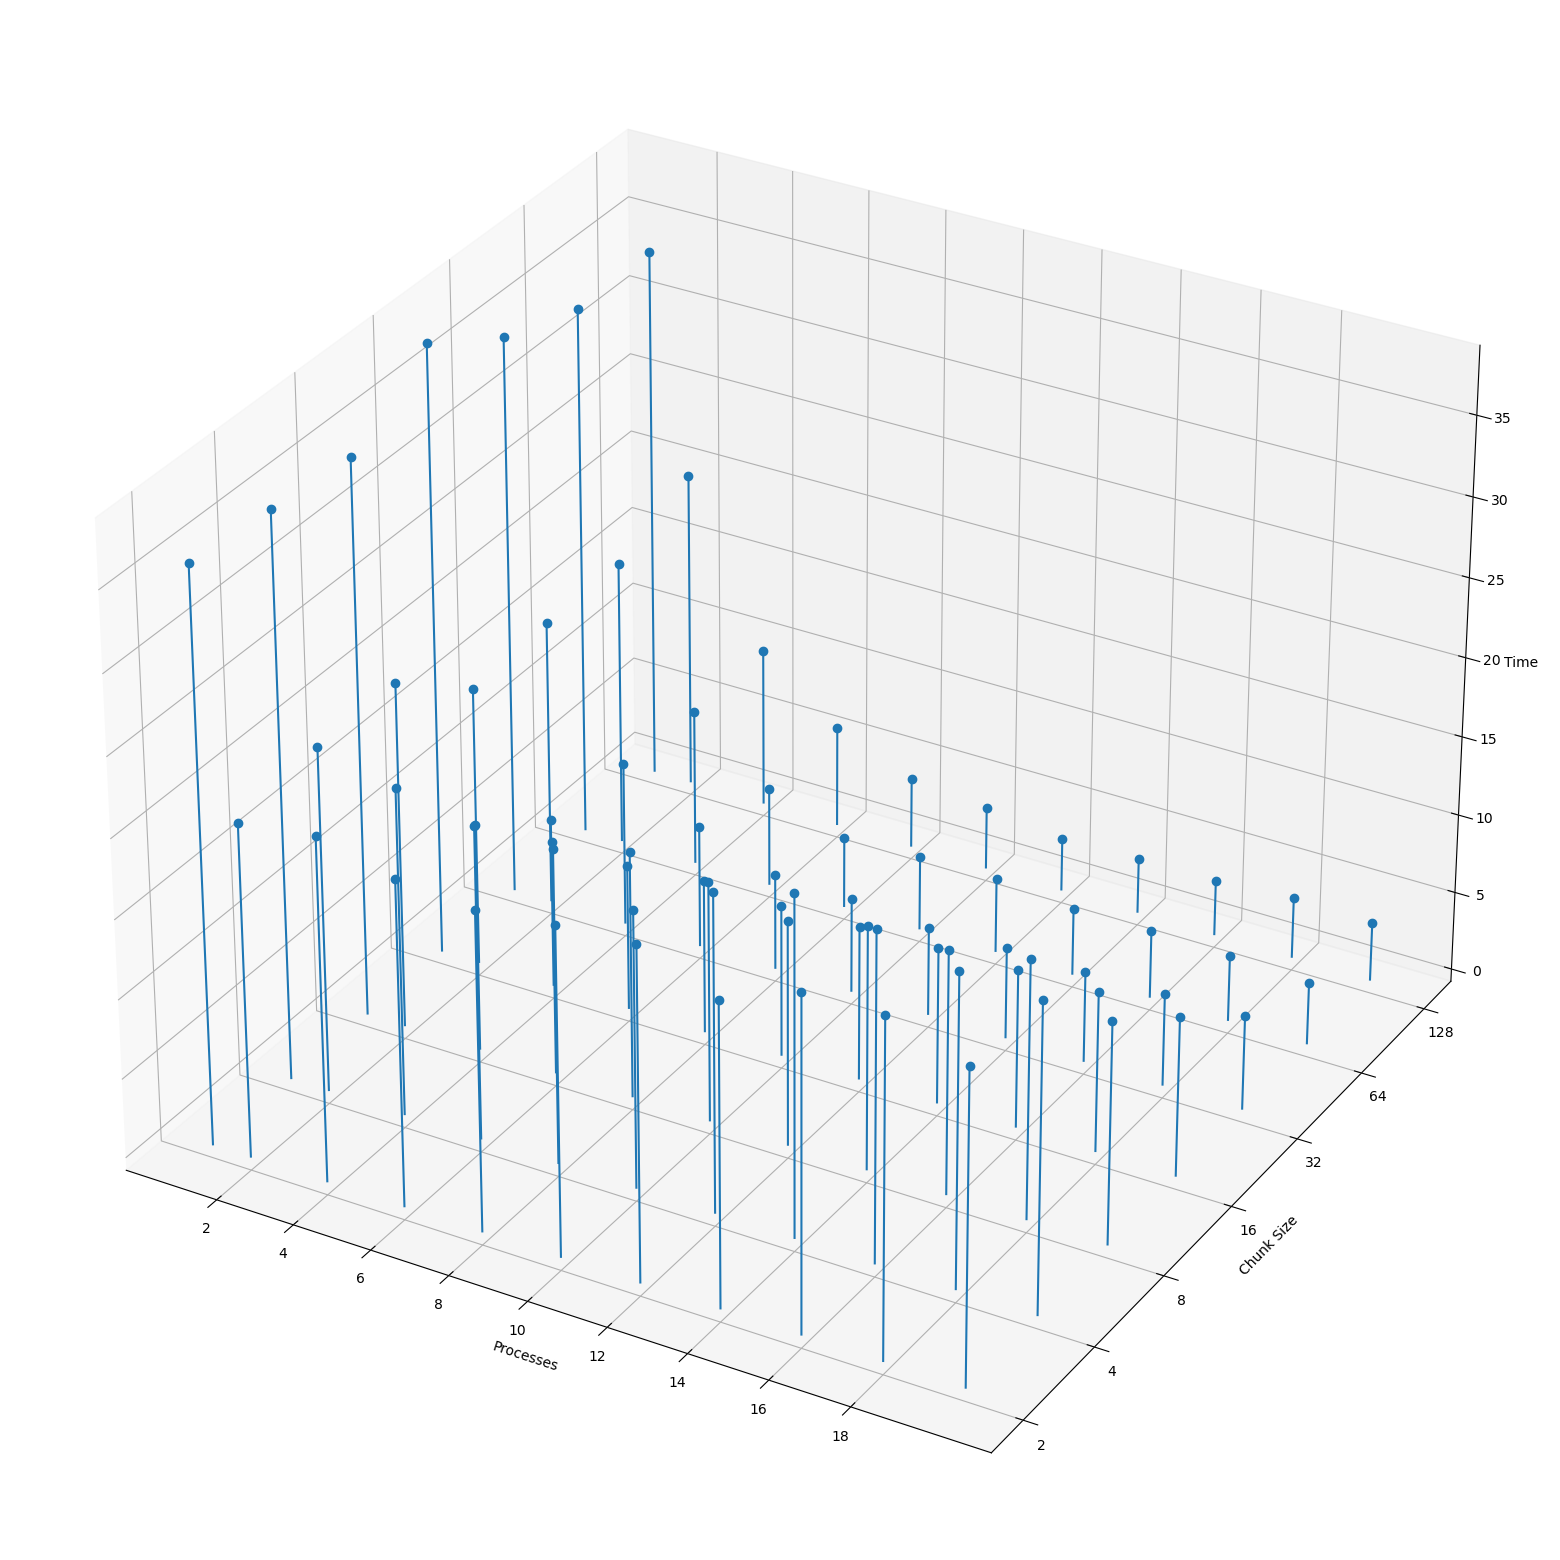

In [20]:
fig = ploterino.figure()
ploterino.rcParams["figure.figsize"] = [5, 5]
ax = fig.add_subplot(projection='3d')

xs = []
ys = []

yticks = range(0, len(chunks))

for p in P:
    for yt in yticks:
        xs.append(p)
        ys.append(yt)

ax.stem(xs, ys, all_t_multiprocessing, basefmt=' ',)

ax.set_xlabel('Processes')
ax.set_ylabel('Chunk Size')
ax.set_zlabel('Time')
ax.set_xticks(range(2,P[-1], 2))
ax.set_yticks(yticks)
ax.set_yticklabels(chunks)

ploterino.show()


As seen from the plot, the best combination of processes and chunk sizes for a 500x000 complex matrix C, is 12 processes and 128 chunks

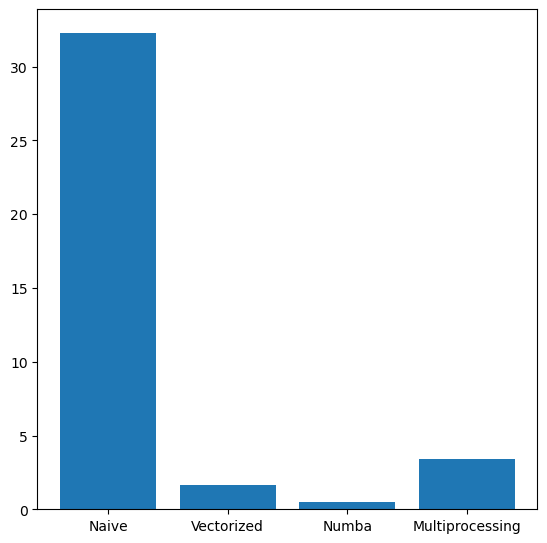

In [22]:
fig = ploterino.figure()
ploterino.rcParams["figure.figsize"] = [5, 5]
ax = fig.add_axes([0, 0, 1, 1])

langs = ['Naive', 'Vectorized', 'Numba', 'Multiprocessing']
times = [t_naive, t_vectorized, t_numba, t_multiprocessing]
ax.bar(langs, times)
ploterino.show()

The implementations have been performed on a C dim of 500x500.
As seen from the plots, the numba version is the fastest, followed by the vectorized, then multiprocessing version (12 cores, 128 chunks) and finally the naive.

### Plot the matrix M

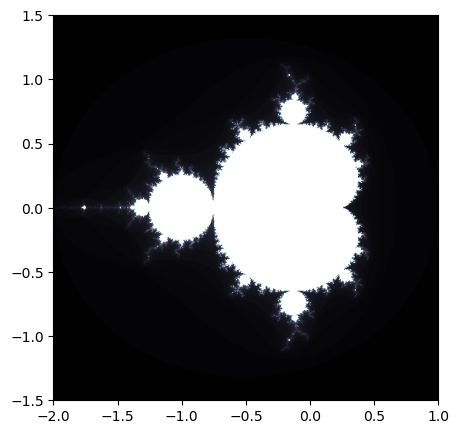

In [23]:
ploterino.imshow(M, cmap='bone', extent=(-2, 1, -1.5, 1.5))
ploterino.rcParams["figure.figsize"] = [20, 20]
ploterino.rcParams["figure.dpi"] = 100
ploterino.show()